# One Outlier (Section 4.1)

This file contains an experiment identifying a single influential point that can cause a sign flip, which AMIP fails to detect.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from linear_regression import LinearRegression

## Data Generation.

In [26]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0) 
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:1]
x2 = x[1:]

# Generating the Y values.
y1 = [1e6]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
intercept = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + intercept + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
y

array([ 1.00000000e+06,  1.34828278e+00,  1.14233802e+00, ...,
       -1.19452582e+00, -1.35971415e+00,  1.30576986e+00])

## Model Fitting

Fit the data using OLS regression.

In [28]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.9999999965167042
Estimated beta1 pop A: 0.999999999999
Estimated beta1 pop B: -0.9556518119674469


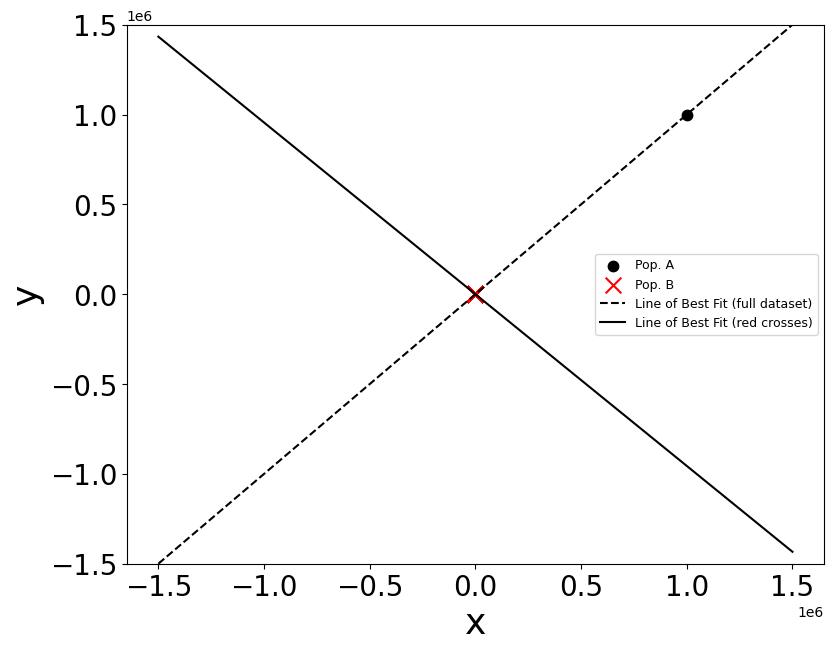

In [49]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=128)

x_values = np.linspace(-1.5e6, 1.5e6, 100)
y_values_full = lr.beta[1] * x_values
y_value_red_crosses = modified_lr.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--', label='Line of Best Fit (full dataset)') 
plt.plot(x_values, y_value_red_crosses, color='black', label='Line of Best Fit (red crosses)')

plt.ylim(-1.5e6, 1.5e6)

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.xticks(fontsize=20) 
plt.yticks(fontsize=20)

plt.legend(fontsize=9)
plt.savefig('one_outlier_example.pdf')
plt.show()

## Additive and Greedy algorithms.


In [59]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

#### Additive Algorithms.

In [60]:
outlier_df = compute_scores(x, y, lr)
outlier_df.head(10)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1000000.000000,1000000.000000,0.001969,1.000,-1.969326e-09,-1.955651e+00,328,0,-9.108152e-09,-1.955651e+00
1,0.529883,1.348283,0.816886,0.001,8.164371e-10,8.172543e-10,73,328,-6.487226e-09,-9.117269e-09
2,-0.642997,1.142338,1.783821,0.001,1.784936e-09,1.786723e-09,389,73,-5.975661e-09,-6.493719e-09
3,0.445034,0.474650,0.028102,0.001,2.808867e-11,2.811678e-11,96,389,-5.922130e-09,-5.981643e-09
4,-0.361321,1.832181,2.191988,0.001,2.192740e-09,2.194935e-09,298,96,-5.313903e-09,-5.928058e-09
5,0.425207,-1.753912,-2.180633,0.001,-2.179664e-09,-2.181846e-09,486,298,-5.236597e-09,-5.319222e-09
6,-0.319134,-1.555891,-1.238270,0.001,-1.238643e-09,-1.239883e-09,274,486,-5.085559e-09,-5.241839e-09
7,-0.630369,-0.023487,0.605368,0.001,6.057383e-10,6.063447e-10,517,274,-5.055223e-09,-5.090650e-09
8,-0.649475,0.205817,0.853778,0.001,8.543169e-10,8.551720e-10,580,517,-4.980365e-09,-5.060283e-09
9,0.394122,-0.079413,-0.475049,0.001,-4.748529e-10,-4.753282e-10,32,580,-4.937179e-09,-4.985351e-09


In [61]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(outlier_df["sorted_IF_scores"][:1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is {round(lr.beta[1] + sum(outlier_df["sorted_1Exact_scores"][:1]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 1 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 1.0.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is -0.9557.
The true change induced by dropping the worst-case subset of size at most 1 is -0.9557.


#### Greedy Algorithms.

Greedy approximations for 1 data point is the same as the additive approximations.


## For Creating the Table and Leverage Plot in Appendix.

In [62]:
### Helpers.
def plot_regression(x, y, x1, y1, x2, y2):
    ## X vs Y
    plt.scatter(x1[0], y1, marker='o', color='black', label='Pop. A', s=56)
    plt.scatter(x2[0], y2, marker='x', color='r', label='Pop. B', s=56)
    # plt.title('One-dimensional Example')
    
    plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
    plt.ylabel('y', fontsize=22)  # Larger font for y-axis label
    
    # Set the size of tick marks
    plt.xticks(fontsize=12)  # Larger ticks for x-axis
    plt.yticks(fontsize=12)  # Larger ticks for y-axis
    
    plt.legend(fontsize=22)

    plt.show()

    x = x.T
    lr = LinearRegression(x=x.T, y=y)
    lr.fit()
    print(
        f"Beta with full dataset: {lr.beta[0]}"
    )

    # Dropping just x1 should change the analysis (based on data generating process)
    modified_lr = LinearRegression(x=x2, y=y2) # Drop Pop_1 data
    modified_lr.fit()
    print(
        f"Beta with subset dropped: {modified_lr.beta[0]}"
    )
    
    return lr

def make_df(lr):
    # III. Compute influence scores and Newton scores for first coefficient.
    scores = -lr.influence_scores()[0] # after adding an intercept term, take the scores of coefficient 1.
    newton_scores = -lr.one_step_newton()[0]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    # print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    # print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    # print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    # print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores
    
    # influential point
    outlier_x = np.squeeze(x1[0][0])
    outlier_y = np.squeeze(y1[0][0])
    print(f"outlier_x: {outlier_x}")
    print(f"outlier_y: {outlier_y}")
    # residuals
    residuals = lr.residual()
    # print(f"outlier_residual: {round(residuals[0], 4)}")
    # leverages
    leverages = lr.leverage_scores()
    # print(f"outlier_leverage: {round(leverages[0], 4)}")
    # schmeverage e1
    shmeverage_e1 = lr.schmeverage_scores([(1,)])
    # print(f'schmeverage_e1: {round(shmeverage_e1[0], 4)}')
    # Compute influence functions for first coefficient
    scores = -lr.influence_scores()[0] # effect of removing a data point on beta1.
    # print("outlier influence score:", round(scores[0], 4))
    leverage_correction = 1 / (1 - leverages)


    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x.flatten(), 'y':y.flatten(),
                            'residual': residuals, 'schmeverage': shmeverage_e1,
                            'leverage': leverages, 'leverage_correction': leverage_correction,
                            'influence': scores, 'newton': newton_scores})
    
    return orig_df

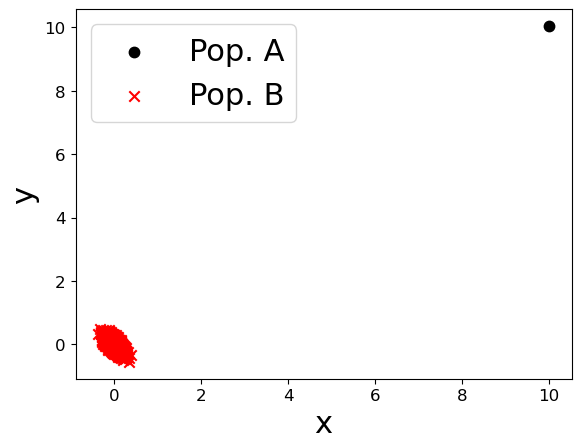

Beta with full dataset: [0.34967025]
Beta with subset dropped: [-0.99827176]
outlier_x: 10
outlier_y: 10.041440587671698


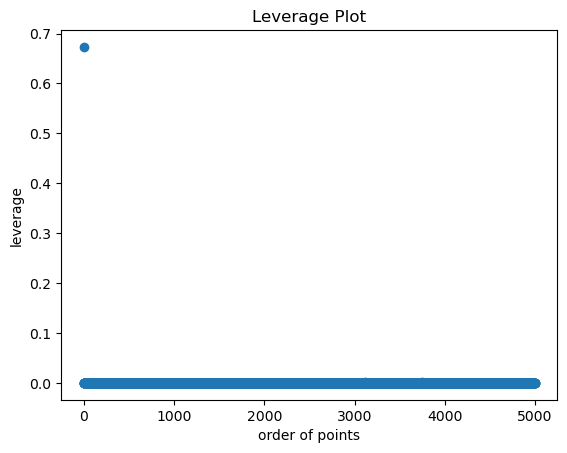

           x          y  residual  schmeverage  leverage  leverage_correction  \
0  10.000000  10.041441  6.544738     0.067316  0.673158             3.059581   
1   0.176405  -0.145433 -0.207117     0.001187  0.000209             1.000210   
2   0.040016  -0.113761 -0.127754     0.000269  0.000011             1.000011   
3   0.097874  -0.251566 -0.285789     0.000659  0.000064             1.000064   
4   0.224089  -0.280315 -0.358672     0.001508  0.000338             1.000338   

   influence    newton  
0  -0.440564 -1.347942  
1   0.000246  0.000246  
2   0.000034  0.000034  
3   0.000188  0.000188  
4   0.000541  0.000541  


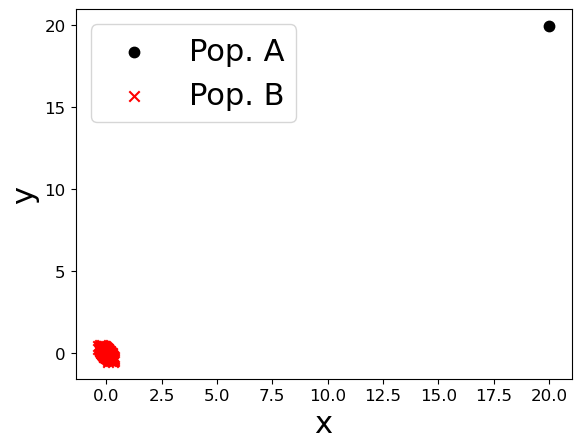

Beta with full dataset: [0.77760076]
Beta with subset dropped: [-1.00594992]
outlier_x: 20
outlier_y: 19.941896719337525


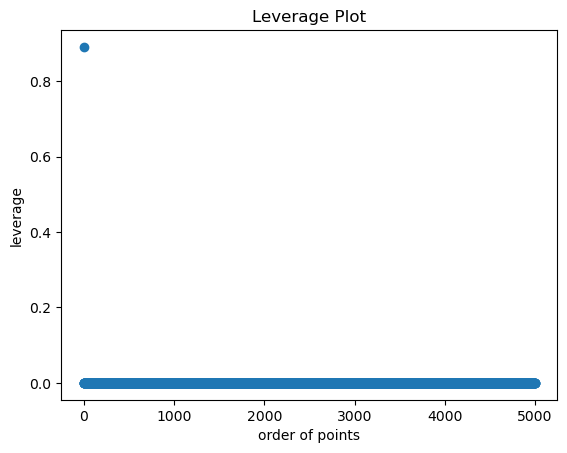

           x          y  residual  schmeverage      leverage  \
0  20.000000  19.941897  4.389881     0.044521  8.904198e-01   
1   0.129811  -0.149649 -0.250590     0.000289  3.751101e-05   
2  -0.020212   0.267210  0.282927    -0.000045  9.093700e-07   
3  -0.083323   0.142025  0.206817    -0.000185  1.545488e-05   
4   0.173360  -0.213095 -0.347900     0.000386  6.690102e-05   

   leverage_correction  influence    newton  
0             9.125735  -0.195442 -1.783551  
1             1.000038   0.000072  0.000072  
2             1.000001   0.000013  0.000013  
3             1.000015   0.000038  0.000038  
4             1.000067   0.000134  0.000134  


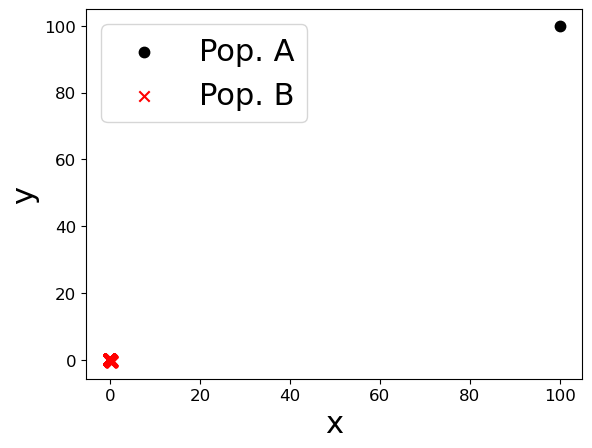

Beta with full dataset: [0.9896772]
Beta with subset dropped: [-0.99283038]
outlier_x: 100
outlier_y: 99.94393556859534


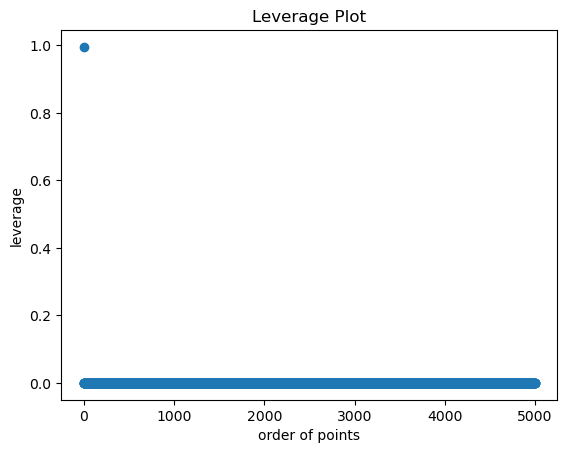

            x          y  residual   schmeverage      leverage  \
0  100.000000  99.943936  0.976216  9.951000e-03  9.951000e-01   
1   -0.105893  -0.070134  0.034667 -1.053742e-05  1.115841e-06   
2   -0.032653   0.076359  0.108674 -3.249284e-06  1.060984e-07   
3    0.033005  -0.002792 -0.035456  3.284287e-06  1.083965e-07   
4   -0.000048   0.014723  0.014770 -4.776275e-09  2.292514e-13   

   leverage_correction     influence        newton  
0           204.080907 -9.714322e-03 -1.982508e+00  
1             1.000001  3.652957e-07  3.652961e-07  
2             1.000000  3.531137e-07  3.531137e-07  
3             1.000000  1.164487e-07  1.164487e-07  
4             1.000000  7.054596e-11  7.054596e-11  


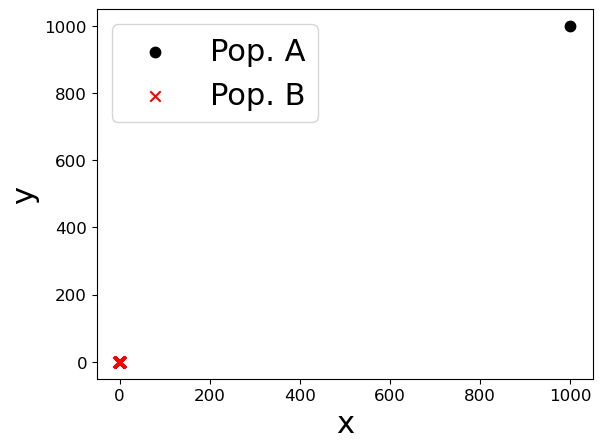

Beta with full dataset: [0.99979787]
Beta with subset dropped: [-1.03119887]
outlier_x: 1000
outlier_y: 999.9019043360779


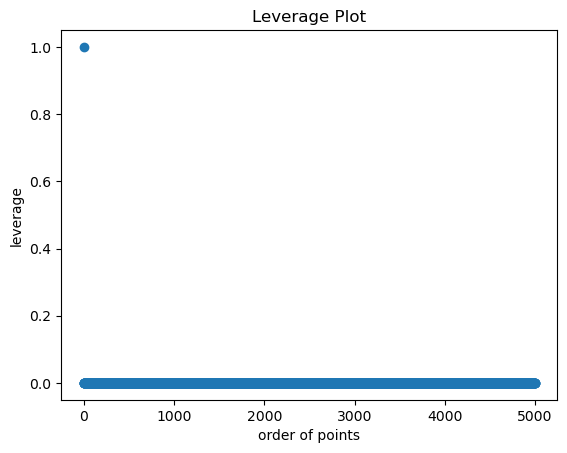

             x           y  residual   schmeverage      leverage  \
0  1000.000000  999.901904  0.104036  9.999488e-04  9.999488e-01   
1    -0.151128    0.046277  0.197374 -1.511199e-07  2.283839e-08   
2     0.097684   -0.084695 -0.182360  9.767938e-08  9.541750e-09   
3     0.125550    0.024569 -0.100956  1.255436e-07  1.576201e-08   
4     0.037123    0.001600 -0.035516  3.712131e-08  1.378062e-09   

   leverage_correction     influence        newton  
0         19523.095345 -1.040305e-04 -2.030997e+00  
1             1.000000  2.982710e-08  2.982710e-08  
2             1.000000  1.781279e-08  1.781279e-08  
3             1.000000  1.267434e-08  1.267434e-08  
4             1.000000  1.318393e-09  1.318393e-09  


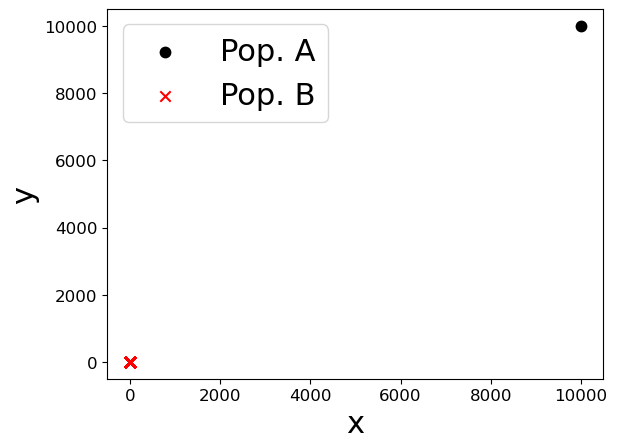

Beta with full dataset: [0.99999604]
Beta with subset dropped: [-0.99194589]
outlier_x: 10000
outlier_y: 9999.970169793554


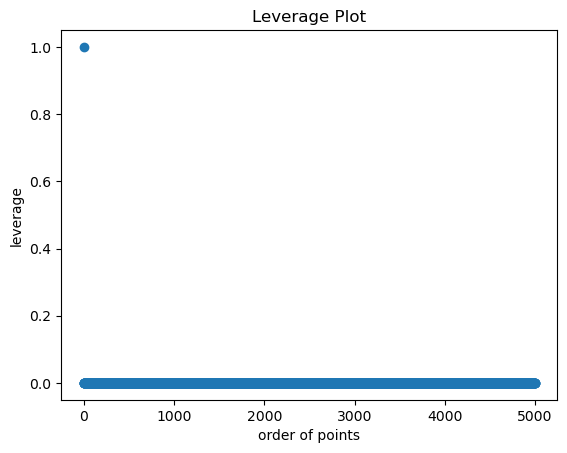

              x            y  residual   schmeverage      leverage  \
0  10000.000000  9999.970170  0.009758  9.999995e-05  9.999995e-01   
1      0.201111    -0.246942 -0.448052  2.011114e-09  4.044581e-10   
2      0.168986    -0.070753 -0.239738  1.689857e-09  2.855617e-10   
3      0.019997    -0.014745 -0.034742  1.999664e-10  3.998658e-12   
4     -0.122433     0.050749  0.173181 -1.224330e-09  1.498985e-10   

   leverage_correction     influence        newton  
0         2.041448e+06 -9.757496e-07 -1.991942e+00  
1         1.000000e+00  9.010840e-10  9.010840e-10  
2         1.000000e+00  4.051231e-10  4.051231e-10  
3         1.000000e+00  6.947187e-12  6.947187e-12  
4         1.000000e+00  2.120308e-10  2.120308e-10  


In [63]:
# Set seed before generating random numbers
np.random.seed(0)
num_dimensions = 1

num_observations_pop_1 = 1
num_observations_pop_2 = 4999

# set variance of pop. big
epsilon = 0.01
vars_pop_2 = [[epsilon]]

# set outlier
outlier_x_list = [[10], [20], [100], [1000], [10000]]

for outlier_x in outlier_x_list:
    x1 = np.expand_dims(outlier_x, axis=0)
    x2 = np.random.randn(1, num_observations_pop_2) * np.sqrt(vars_pop_2) # pop B
    # All x samples
    x = np.concatenate([x1, x2], axis=-1) 

    # generate y's.
    # True regression coefficients for both populations
    beta1 = [[1.0]]
    beta2 = [[-1.0]]
    # Generate Gaussian noise
    noise_stdev = 0.1
    epsilon1 = noise_stdev * np.random.randn(len(x1[0]), 1)
    epsilon2 = noise_stdev * np.random.randn(num_observations_pop_2, 1)
    # Generate observed values
    y1 = (x1.T @ beta1) + epsilon1
    y2 = (x2.T @ beta2) + epsilon2
    y = np.concatenate([y1, y2], axis=0)

    lr = plot_regression(x, y, x1, y1, x2, y2)

    orig_df = make_df(lr)
    ind = np.arange(0, 5000, 1)
    plt.scatter(ind, orig_df['leverage'])
    
    plt.xlabel("order of points")
    plt.ylabel('leverage')
    plt.title('Leverage Plot')
    plt.savefig(f'leverage-for-outlier-{outlier_x}')
    plt.show()
    
    print(orig_df[:5])